> **How to run this notebook (command-line)?**
1. Install the `ReinventCommunity` environment:
`conda env create -f environment.yml`
2. Activate the environment:
`conda activate ReinventCommunity`
3. Execute `jupyter`:
`jupyter notebook`
4. Copy the link to a browser


# `REINVENT 3.2`: Data Preparation demo
This demo illustrates how data from ChEMBL or other sources be processed, analysed and filtered. 

To proceed, please update the following code block such that it reflects your system's installation and execute it.

### Motivation
> **There are a number of reasons to pre-process the data used for training a generative model.**
1. Removal of invalid or duplicated entries.
2. Removal of unusual compounds that are clearly not drug-like (too big, reactive groups and etc.). There is normally no point training model on such examples since that bias will reflected by the generative model. 
3. Removal of rare tokens. There are rare compounds that can be seen as outliers. They in turn might contain rare tokens. Excluding them frees a slot in the vocabulary and makes it smaller. Smaller vocabulary means faster training and less memory. As a result removing compounds that introduce rare tokens to the vocabulary speeds up the generative model.


In [1]:
# load dependencies
import os
import re
import json
import tempfile

# --------- change these path variables as required
DBS_PATH = "./data/chembl.raw.smi"
# --------- to be honest this isn't the exact raw version of ChEMBL
# it has been already put through some filtering
# we should provide the raw version here 
# so that the actual filtering can be illustrated in the plots below

output_dir = os.path.expanduser("~/Desktop/Data_Preparation_demo")
parquet_file = f'{output_dir}/chembl.parquet'

# --------- do not change
# get the notebook's root path
try: ipynb_path
except NameError: ipynb_path = os.getcwd()

# if required, generate a folder to store the results
try:
    os.mkdir(output_dir)
except FileExistsError:
    pass

### We provide as an alternative a smaller dataset for testing purposes
One can use the cell below just to play with the code.
If you intend to process the full dataset don't execute the cell below. The dataset used below is a subset of the raw chembl dataset so that computing time for this notebook is much quicker.

In [2]:
DBS_PATH = "./data/chembl.mini.smi"
parquet_file = f'{output_dir}/chembl.mini.parquet'

In [3]:
%matplotlib inline

import pyspark.sql as ps
import pyspark.sql.functions as psf
import pyspark.sql.types as pst

import rdkit.Chem as rkc
import rdkit.Chem.AllChem as rkac

import molvs as mv

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

%run code/data_preparation.py

In [4]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 200)

sns.set(style="ticks")

In [5]:
SPARK, SC = SparkSessionSingleton.get("clean_db")

In [6]:
def to_mol(smi):
    """
    Creates a Mol object from a SMILES string.
    :param smi: SMILES string.
    :return: A Mol object or None if it's not valid.
    """
    if smi:
        return rkc.MolFromSmiles(smi)


def to_smiles(mol):
    """
    Converts a Mol object into a canonical SMILES string.
    :param mol: Mol object.
    :return: A SMILES string.
    """
    if mol is None:
        return None
    return rkc.MolToSmiles(mol, isomericSmiles=False)

In [7]:
# standardize molecule

STANDARDIZER = mv.Standardizer()
ACCEPTED_ATOMS = [6,7,8,9,16,17,35]

def _run_reaction(mol, rxn):
    while True:
        results = rxn.RunReactants([mol], maxProducts=1)
        if not results:
            return mol
        else:
            mol = results[0][0]

REACTIONS = [
    "[S+:1](=[N:3])[OH:2]>>[S+0:1](=[N:3])=[O:2]",
    "[n+:1][OH:2]>>[n+:1][O-]",
    "[N:1](=[O:2])=[O:3]>>[N+:1]([O-:2])=[O:3]",
    "[S+:1]([O:2])[N:3]>>[S+0:1](=[O:2])[N:3]"
]
REACTIONS = [rkac.ReactionFromSmarts(rxn) for rxn in REACTIONS] 


def standardize_mol(mol, standardize=True, min_size=0, max_size=1000):
    try:
        if standardize:
            for rxn in REACTIONS:
                mol = _run_reaction(mol, rxn)
            
            mol = STANDARDIZER.charge_parent(mol, skip_standardize=True)
            mol = STANDARDIZER.isotope_parent(mol, skip_standardize=True)
            mol = STANDARDIZER.stereo_parent(mol, skip_standardize=True)
            mol = STANDARDIZER.standardize(mol)
            if any([atom.GetAtomicNum() not in ACCEPTED_ATOMS for atom in mol.GetAtoms()]):
                return None
        return mol
    except:
        return None

TOKENIZER = SMILESTokenizer()
tokenize_udf = psf.udf(lambda smi: TOKENIZER.tokenize(smi, with_begin_and_end=False), pst.ArrayType(pst.StringType()))

def _num_rings(smi):
    mol = to_mol(smi)
    if mol:
        return rkc.GetSSSR(mol)
    return None
num_rings_udf = psf.udf(_num_rings, pst.IntegerType())

def _size_largest_ring(smi):
    mol = to_mol(smi)
    if mol:
        ring_info = mol.GetRingInfo()
        return max([0] + [len(ring) for ring in ring_info.AtomRings()])
    return None
size_largest_ring_udf = psf.udf(_size_largest_ring, pst.IntegerType())

num_atoms_udf = psf.udf(lambda smi: to_mol(smi).GetNumHeavyAtoms(), pst.IntegerType())
num_c_atoms_udf = psf.udf(lambda smi: len([atom for atom in to_mol(smi).GetAtoms() if atom.GetAtomicNum() == 6]), pst.IntegerType())

SMARTS_CHAINS = [rkc.MolFromSmarts("-".join(["[CR0H2]"]*i)) for i in range(1, 11)]
def _longest_aliphatic_c_chain(smi):
    mol = to_mol(smi)
    curr_chain = 0
    for chain in SMARTS_CHAINS:
        if mol.HasSubstructMatch(chain):
            curr_chain += 1
        else:
            break
    return curr_chain
longest_aliphatic_c_chain = psf.udf(_longest_aliphatic_c_chain, pst.IntegerType())

# ChEMBL

### Remove Invalid SMILES

In [8]:
def _process_rows(row):
    fields = row.split(" ")
    mol = to_mol(fields[0])
    standardized_smiles = None
    if mol:
        standardized_mol = standardize_mol(mol)
        standardized_smiles = to_smiles(standardized_mol)
    return ps.Row(original_smiles=fields[0], smiles=standardized_smiles)

In [9]:
chembl_df = SPARK.createDataFrame(SC.textFile(DBS_PATH).repartition(5000).map(_process_rows)).distinct().where("smiles is not null")

In [10]:
chembl_df.count()

171508

### Write down to a parquet file as a checkpoint.
You can do that at multiple instances where the processing steps take while so that next time can resume from this checkpoint.

In [11]:
chembl_df.write.parquet(parquet_file)

### Load from the checkpoint

In [12]:
chembl_df = SPARK.read.parquet(parquet_file)

### Calculate various metrics for each SMILES entry

In [13]:
chembl_annotated_df = chembl_df\
    .withColumn("num_atoms", num_atoms_udf("smiles"))\
    .withColumn("c_atom_ratio", num_c_atoms_udf("smiles") / psf.col("num_atoms"))\
    .withColumn("tokens", tokenize_udf("smiles"))\
    .withColumn("num_rings", num_rings_udf("smiles"))\
    .withColumn("size_largest_ring", size_largest_ring_udf("smiles"))\
    .withColumn("num_tokens", psf.size("tokens"))\
    .withColumn("tokens_atom_ratio", psf.col("num_tokens")/psf.col("num_atoms"))\
    .withColumn("longest_aliph_c_chain", longest_aliphatic_c_chain("smiles"))\
    .persist()

## Data purging
In the section below we look at various calculated parameters and apply some arbitrary criteria to eliminate entries that dont meet those.

### Num atoms distribution

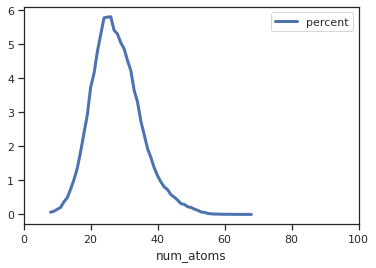

In [14]:
num_atoms_dist = chembl_annotated_df\
    .groupBy("num_atoms")\
    .agg(psf.count("num_atoms").alias("num"))\
    .withColumn("percent", psf.lit(100.0)*psf.col("num")/chembl_annotated_df.count())\
    .sort("num_atoms", ascending=False)\
    .toPandas()
num_atoms_dist.plot(x="num_atoms", y="percent", xlim=(0, 100), lw=3)

In [15]:
num_atoms_dist

,num_atoms,num,percent
0,68,1,0.000583
1,66,2,0.001166
2,65,3,0.001749
3,64,4,0.002332
4,63,1,0.000583
5,62,7,0.004081
6,61,6,0.003498
7,60,9,0.005248
8,59,11,0.006414
9,58,18,0.010495


In [16]:
chembl_chemistry_filtered_df = chembl_annotated_df.where("num_atoms >= 6 and num_atoms <= 70")
chembl_chemistry_filtered_df.count()

171508

### Number of rings

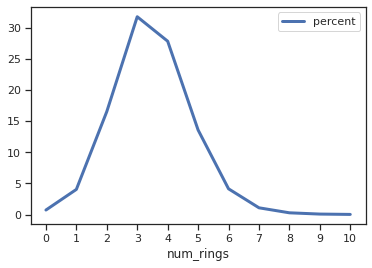

In [17]:
num_rings_dist = chembl_chemistry_filtered_df\
    .groupBy("num_rings")\
    .agg(psf.count("num_atoms").alias("num"))\
    .withColumn("percent", psf.lit(100.0)*psf.col("num")/chembl_chemistry_filtered_df.count())\
    .sort("num_rings", ascending=False)\
    .toPandas()
num_rings_dist.plot(x="num_rings", y="percent", lw=3, xticks=num_rings_dist["num_rings"])

In [18]:
num_rings_dist

,num_rings,num,percent
0,10,47,0.027404
1,9,141,0.082212
2,8,489,0.285118
3,7,1865,1.087413
4,6,7091,4.134501
5,5,23268,13.566714
6,4,47685,27.803368
7,3,54414,31.726800
8,2,28333,16.519929
9,1,6925,4.037713


In [19]:
chembl_chemistry_filtered_df = chembl_chemistry_filtered_df.where("num_rings <= 10")
chembl_chemistry_filtered_df.count()

171508

### Size of largest ring

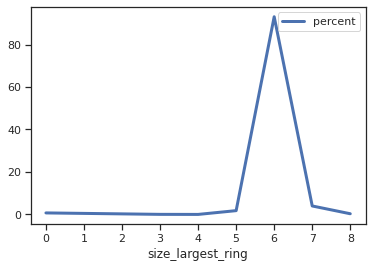

In [20]:
size_largest_ring_dist = chembl_chemistry_filtered_df\
    .groupBy("size_largest_ring")\
    .agg(psf.count("size_largest_ring").alias("num"))\
    .withColumn("percent", psf.lit(100.0)*psf.col("num")/chembl_chemistry_filtered_df.count())\
    .sort("size_largest_ring", ascending=False)\
    .toPandas()
size_largest_ring_dist.plot(x="size_largest_ring", y="percent", lw=3)

In [21]:
chembl_chemistry_filtered_df = chembl_chemistry_filtered_df.where("size_largest_ring < 9")
chembl_chemistry_filtered_df.count()

171508

### Long aliphatic C chains

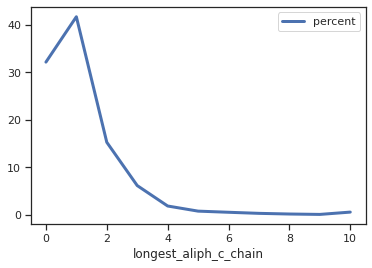

In [22]:
longest_aliph_c_chain = chembl_chemistry_filtered_df\
    .groupBy("longest_aliph_c_chain")\
    .agg(psf.count("longest_aliph_c_chain").alias("num"))\
    .withColumn("percent", psf.lit(100.0)*psf.col("num")/chembl_chemistry_filtered_df.count())\
    .sort("longest_aliph_c_chain", ascending=False)\
    .toPandas()
longest_aliph_c_chain.plot(x="longest_aliph_c_chain", y="percent", lw=3)

In [23]:
longest_aliph_c_chain

,longest_aliph_c_chain,num,percent
0,10,1075,0.626793
1,9,241,0.140518
2,8,386,0.225062
3,7,623,0.363248
4,6,1013,0.590643
5,5,1424,0.830282
6,4,3272,1.907783
7,3,10633,6.199711
8,2,26239,15.298995
9,1,71478,41.676190


In [24]:
chembl_chemistry_filtered_df = chembl_chemistry_filtered_df.where("longest_aliph_c_chain < 5")
chembl_chemistry_filtered_df.count()

166746

### Heteroatom ratios

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7eff80ca1a90>]],
      dtype=object)

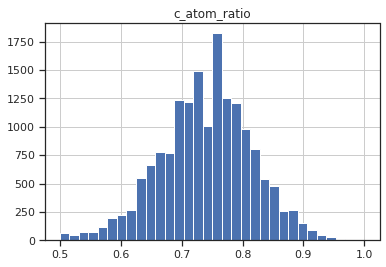

In [25]:
c_ratio_dist = chembl_chemistry_filtered_df.sample(False, 0.1).toPandas()
c_ratio_dist.hist(column="c_atom_ratio", bins=32)

In [26]:
chembl_chemistry_filtered_df = chembl_chemistry_filtered_df.where("c_atom_ratio >= 0.5")
chembl_chemistry_filtered_df.count()

166746

### Number of tokens

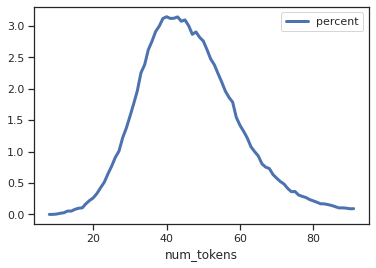

In [27]:
num_tokens_dist = chembl_chemistry_filtered_df\
    .groupBy("num_tokens")\
    .agg(psf.count("num_tokens").alias("num"))\
    .withColumn("percent", psf.lit(100.0)*psf.col("num")/chembl_chemistry_filtered_df.count())\
    .sort("num_tokens", ascending=False)\
    .toPandas()
num_tokens_dist.plot(x="num_tokens", y="percent", lw=3)

In [28]:
num_tokens_dist

,num_tokens,num,percent
0,91,154,0.092356
1,90,151,0.090557
2,89,167,0.100152
3,88,175,0.104950
4,87,173,0.103751
5,86,206,0.123541
6,85,238,0.142732
7,84,262,0.157125
8,83,280,0.167920
9,82,283,0.169719


In [29]:
chembl_filtered_df = chembl_chemistry_filtered_df.where("num_tokens <= 91")
chembl_filtered_df.count()

166746

### Tokens/atom ratio

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7eff80a24610>]],
      dtype=object)

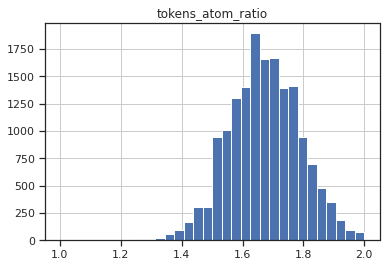

In [30]:
tokens_atom_ratio_dist = chembl_filtered_df.sample(False, 0.1).toPandas()
tokens_atom_ratio_dist.hist(column="tokens_atom_ratio", bins=32)

In [31]:
chembl_filtered_df = chembl_filtered_df.where("tokens_atom_ratio <= 2.0")
chembl_filtered_df.count()

166745

### Token/molecule distribution

In [32]:
token_dist = chembl_filtered_df\
    .withColumn("unique_tokens", psf.array_distinct("tokens"))\
    .select(psf.explode("unique_tokens").alias("token"))\
    .groupBy("token")\
    .agg(psf.count("token").alias("num"))\
    .withColumn("percent", psf.lit(100.0)*psf.col("num")/chembl_filtered_df.count())\
    .sort("percent", ascending=False)\
    .toPandas()
token_dist

,token,num,percent
0,1,165974,99.537617
1,(,165883,99.483043
2,),165883,99.483043
3,C,164374,98.578068
4,c,161352,96.765720
5,O,153479,92.044139
6,=,148611,89.124711
7,2,147905,88.701310
8,N,138062,82.798285
9,n,89681,53.783322


In [33]:
tokens_to_remove = token_dist[(token_dist["percent"] < 5E-2) & (token_dist["token"].str.startswith("[")) & ~(token_dist["token"].isin(["[S+]", "[s+]"]))]["token"]
query_tokens = psf.lit(False)
for token in tokens_to_remove:
    query_tokens |= psf.array_contains("tokens", token)

chembl_filtered_df = chembl_filtered_df.where(~query_tokens).select("original_smiles", "smiles")
chembl_filtered_df.count()

166745

## Write the filtered dataset to disk
We finally write out all SMILES that meet the filtering criteria to a csv file and to a parquet.

In [34]:
filtered_parquet_file = f'{output_dir}/final.filtered.parquet'
filtered_csv_file = f'{output_dir}/final.filtered.csv'
chembl_filtered_df.write.parquet(filtered_parquet_file)
chembl_filtered_df.select("smiles").toPandas().to_csv(filtered_csv_file, index=False, header=False)